## Previsão da classificação da Premier League usando distribuição de Poisson

A distribuição de Poisson é usada para a distribuição de probabilidade de marcar gols.
Este modelo é então aplicado para simular partidas da liga e prever os pontos marcados por cada equipe para construir a classificação final da liga.Artigo Original de Apaar Gupta publicado em jan 2019 [Aqui](https://towardsdatascience.com/predicting-premier-league-standings-putting-that-math-to-some-use-e8de64938d7)

![Foto 1](https://miro.medium.com/max/875/1*lG1RjzIluQnCrsMRWlQaCw.jpeg)

In [19]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import poisson 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Recentemente me deparei com uma tarefa de problema interessante, cortesia do desafio final de uma caça à cripta online baseada em matemática e outros temas divertidos (matemática e diversão geralmente não combinam: P), e minha tentativa de uma solução reunida em um curto período de tempo não foi tão ruim. Neste artigo, tento descrever a abordagem de solução que usei e discutir algumas melhorias possíveis.

A tarefa do problema em palavras simples era:

> **Preveja a classificação final do Manchester United F.C. na tabela de pontos da atual temporada (18-19) da Premier League inglesa**


Alguns antecedentes
---
***
A Premier League é o nível mais alto do sistema da liga inglesa de futebol e é a liga esportiva mais assistida do mundo, com uma audiência potencial de TV de 4,7 bilhões de pessoas (sim, é tão popular!).   
Vinte clubes competem ao longo de uma temporada, com cada clube jogando contra os outros duas vezes (um sistema de rodízio duplo), uma vez em seu estádio e uma vez fora, no estádio de seus adversários em um total de 38 jogos por equipe.  
O Manchester United, o clube de futebol com sede em Old Trafford, é o clube de maior sucesso, com um recorde de 20 títulos da liga e um dos clubes de futebol mais amplamente apoiados no mundo.   
Mais tarde, no entanto, o clube tem sofrido com uma mistura de problemas de gestão e de investimento, já se passaram (quase) seis anos desde a última vez que conquistou o prestigioso título.



> Eu sou um fã casual quando se trata de futebol, mas a ideia de construir um modelo matemático que pode ser aplicado a um problema do mundo real parecia excitante o suficiente para tentar. (Vamos começar então, vamos?⚽️)

![Figura](https://miro.medium.com/max/590/1*c1RSNRLX2XFaCI4Z_x7Kmw.jpeg)

Resolvendo o problema
---
***
A classificação na tabela de classificação é determinada principalmente pela contagem de pontos para cada equipe, com os empates divididos por saldo de gols.   

Para prever a classificação final do Man United, foi, portanto, necessário estimar o total de pontos para todas as equipes. O problema é então reduzido a prever o resultado para todos os jogos da partida.   

Por razões de simplicidade, pode-se supor que cada um dos resultados da correspondência é independente um do outro, ou seja, o resultado de qualquer correspondência X é independente de qualquer outra correspondência Y.  

Uma partida entre duas equipes pode terminar em 3 resultados possíveis: Vitória da equipe da casa (H), Vitória da equipe fora (A) ou Empate (T). As equipes recebem 3 pontos por vitória e 1 ponto por empate.  

Podemos escolher resultados aleatoriamente, mas esse não é um bom modelo para ajustar o cenário do mundo real.  

Praticamente, um time de primeira linha tem uma chance melhor de vencer contra um time de baixo escalão e mais fraco. Portanto, alguns parâmetros são necessários para medir a força da equipe

Obtenção de dados e escolha de parâmetros
---
***
Que melhor maneira de medir o desempenho de uma equipe do que olhar seus dados anteriores. Usei os conjuntos de dados disponíveis em [http://www.football-data.co.uk/data], que consistem em todos os resultados das partidas desde a formação da Premier League em 92, compilados ordenadamente em arquivos CSV. 

A próxima etapa foi determinar os fatores dominantes que se correlacionam bem com a força da equipe. Tenho que mencionar esta [excelente postagem](https://theartandscienceofdata.wordpress.com/2016/09/17/predicting-the-english-premier-league-standings/) no blog que forneceu alguns ótimos insights sobre a compreensão das variáveis, junto com visualizações muito legais. Os seguintes pontos podem ser concluídos:


In [2]:
# Fetch Dataset : Premier League Data since Season 2005-06
dfList = []
for i in range(5, 19):
    df = pd.read_csv("http://www.football-data.co.uk/mmz4281/{0:02d}{1:02d}/E0.csv".format(i,i+1))
    df = df[['HomeTeam','AwayTeam','FTHG','FTAG']]
    df = df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
    dfList.append(df)
    
eplData = dfList[0].append(dfList[1:])

# Fetch current standings (as of 29-01-2019)
eplPointsTable = pd.read_excel('PointsTable.xlsx')[['Team', 'Points']]
eplPointsTable.index = np.arange(1, len(eplPointsTable) + 1)

# Fetch upcoming match fixures
eplMatchesLeft = pd.read_excel('MatchesLeft.xlsx')

>1. Fatores como número de excanteios, faltas, cartões vermelhos e amarelos têm uma relação fraca com a contagem de pontos e, portanto, com a força da equipe.   
>2. O fator mais significativo com a correlação positiva mais alta é a diferença de gols, que basicamente se traduz no equilíbrio entre a força de ataque e defesa de uma equipe.   
>3. Curiosamente, o número de tiros acaba sendo inversamente correlacionado! Isso significa que quanto mais o número de chutes de uma equipe, menos pontos ela terá probabilidade de atingir 😮.    
>4. Embora pareça desafiar a lógica no início, em retrospectiva, cada tentativa de chute que não se transforma em um gol invariavelmente devolve a posse para o time adversário e dá a eles a vantagem, daí a correlação negativa.  

Seguindo um modelo simples, decidi então usar como parâmetro a contagem de gols em tempo integral da equipe da casa e visitante.

Usando a matemática
---
***
Na verdade, o resultado da partida é baseado no número de gols marcados em cada lado. Portanto, precisamos modelar a distribuição de probabilidade dos gols marcados. Um dos métodos mais comuns para fazer isso é por meio da distribuição de Poisson. (Fonte)   


> **A distribuição de Poisson mede a probabilidade de um determinado número de eventos ocorrerem em um intervalo fixo de tempo se esses eventos ocorrerem com uma taxa constante conhecida e independentemente do tempo desde o último evento.***



![Poisson](https://miro.medium.com/max/279/1*K7jb9jIysxBGvLPIiCU6mw.jpeg)

![Poisson_Image](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Poisson_distribution_PMF.png/1200px-Poisson_distribution_PMF.png)

Para entender por que esse modelo se encaixa em nosso caso, podemos considerar um gol marcado como um evento. Então, dentro do intervalo de 90 minutos de jogo, cada evento pode ocorrer qualquer número de vezes de forma independente.

Para dar um exemplo, vamos tentar prever a probabilidade de que uma partida entre Arsenal e Leicester City termine com o placar de 2–1.

Digamos que os seguintes números sejam obtidos:

Número médio de gols marcados pelo Arsenal = 1,842

Número médio de gols marcados por Leicester City = 1.500

Então,

>A) Probabilidade de o Arsenal marcar 2 gols = P (X = 2, $\lambda$ = 1,842) = 27,8%  
>B) Probabilidade de Leicester marcar 1 gol = P (X = 1, $\lambda$ = 1,5) = 33,4%

Portanto, probabilidade da linha de pontuação 2-1 = (A) * (B) = 9,2%

O que resta então é descobrir a taxa constante ($\lambda$):  

Pode-se perceber intuitivamente que este parâmetro reflete o desempenho de uma equipe, sendo que a melhor equipe tem um índice de gols em média maior. 

Além disso, esta taxa dependeria tanto da força de ataque da equipe quanto da força defensiva do adversário. 

Por fim, também temos que levar em consideração o fator casa, ou seja, levar em consideração que uma equipe geralmente joga melhor em casa.  

Com base na discussão acima, podemos definir o parâmetro $\lambda$ como o número médio de gols marcados por uma equipe em um determinado local, que pode ser calculado usando os dados anteriores.

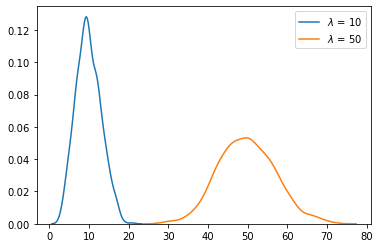

In [23]:

import seaborn as sns

sns.distplot(np.random.poisson(lam=10, size=1000), hist=False, label='$\lambda$ = 10');
sns.distplot(np.random.poisson(lam=50, size=1000), hist=False, label='$\lambda$ = 50');

plt.show()

Construindo o modelo
---
***
Vamos construir algumas estatísticas então:

### Para cada equipe, podemos calcular:
***
>a) Gols Marcados Home = número médio de gols marcados em jogos em casa

>b) Gols Concedidos Home = Número médio de gols sofridos em jogos em casa

>c) Gols Away marcados = número médio de gols marcados em partidas fora

>d) Gols Away Concedido = Número médio de gols sofridos em partidas Fora

### A seguir calculamos os mesmos resultados, mas para toda a liga: e) Pontuação da Liga Home

>f) Liga em casa concedida 

>g) Liga fora marcada 

>h) Liga fora concedida


### Usando acima, podemos atribuir parâmetros normalizados a cada equipe: 

>i)Força do Ataque Home = (a)/(e) 

>j) Força do Home Defense = (b)/(f) 

>k) Força de ataque Away = (c)/(g) 

>l) Força de defesa fora = (d)/(h)



### Finalmente, calculamos os multiplicadores:

>n) Gols totais marcados em casa = (e+h)/2 

>p) Gols gerais marcados fora = (f+g)/2

Usando as estatísticas acima, podemos agora formular o parâmetro $\lambda$ da seguinte forma:

Para uma partida entre a equipe da casa (H) e a equipe visitante (A):

> **λ (H) = Ataque em casa (H) * Defesa fora de casa (A) * Pontuação em casa geral (n)**

> **λ (A) = Ataque fora (A) * Defesa em casa (H) * Pontuação geral fora (p)**

In [24]:
'PAST MATCH DATA: {} rows'.format(len(eplData))
eplData.head()
'CURRENT POINTS TABLE'
eplPointsTable
'UPCOMING MATCH FIXTURES: {} rows'.format(len(eplMatchesLeft))
eplMatchesLeft.head()

'PAST MATCH DATA: 5321 rows'

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Aston Villa,Bolton,2.0,2.0
1,Everton,Man United,0.0,2.0
2,Fulham,Birmingham,0.0,0.0
3,Man City,West Brom,0.0,0.0
4,Middlesbrough,Liverpool,0.0,0.0


'CURRENT POINTS TABLE'

,Team,Points
1,Liverpool,60
2,Man City,56
3,Tottenham,51
4,Chelsea,47
5,Arsenal,44
6,Man United,44
7,Watford,33
8,Wolves,32
9,Leicester,31
10,West Ham,31


'UPCOMING MATCH FIXTURES: 150 rows'

,HomeTeam,AwayTeam
0,Arsenal,Cardiff
1,Bournemouth,Chelsea
2,Fulham,Brighton
3,Huddersfield,Everton
4,Wolves,West Ham


Simulando as partidas
Como discutido antes, uma partida entre duas equipes pode terminar em 3 resultados possíveis: 
- Vitória da equipe da casa (H), 
- Vitória da equipe fora (A) ou 
- Empate (T). 
Deixe o time da casa marcar X gols e o time visitante marcar Y gols. Então:



> A equipe da casa ganha se (X> Y)  
> A equipe visitante vence se (X <Y)   
> É um empate se (X = Y)

Já vimos como calcular a probabilidade de que a partida termine com a pontuação X-Y. 

Além disso, podemos colocar um limite superior prático para o número de gols marcados por uma equipe em, digamos, 10. 

Finalmente, como todas as linhas de pontuação são independentes umas das outras, as probabilidades podem ser simplesmente somadas:

Probability (H wins) = $\Sigma P(X-Y scoreline) , X > Y$   

Probability (A wins) = $\Sigma P(X-Y scoreline) , X < Y$ 

Probability (Tie) = $\Sigma P(X-Y scoreline) , X = Y$ 

Assim, podemos simular um jogo entre as equipes da casa (H) e fora (A) e prever os pontos marcados pelas equipes

In [30]:
# Calculate Team and League stats

# For each team - Average {HomeScored, HomeConceded, AwayScored, AwayConceded} 
eplHomeTeam = eplData[['HomeTeam', 'HomeGoals', 'AwayGoals']].rename(
    columns={'HomeTeam':'Team', 'HomeGoals':'HomeScored', 'AwayGoals':'HomeConceded'}).groupby(
    ['Team'], as_index=False)[['HomeScored', 'HomeConceded']].mean()

eplAwayTeam = eplData[['AwayTeam', 'HomeGoals', 'AwayGoals']].rename(
    columns={'AwayTeam':'Team', 'HomeGoals':'AwayConceded', 'AwayGoals':'AwayScored'}).groupby(
    ['Team'], as_index=False)[['AwayScored', 'AwayConceded']].mean()

# Overall - Average {leagueHomeScored, leagueHomeConceded, leagueAwayScored, leagueAwayConceded}
leagueHomeScored, leagueHomeConceded = eplHomeTeam['HomeScored'].mean(), eplHomeTeam['HomeConceded'].mean()
leagueAwayScored, leagueAwayConceded = eplAwayTeam['AwayScored'].mean(), eplAwayTeam['AwayConceded'].mean()

eplTeamStrength = pd.merge(eplHomeTeam, eplAwayTeam, on='Team')

assert(leagueHomeScored != 0)
assert(leagueHomeConceded != 0)
assert(leagueAwayScored != 0)
assert(leagueAwayConceded != 0)

# Normalize the parameters 
# For each team - {HomeAttack, HomeDefence, AwayAttack, AwayDefense}
eplTeamStrength['HomeScored'] /= leagueHomeScored
eplTeamStrength['HomeConceded'] /= leagueHomeConceded
eplTeamStrength['AwayScored'] /= leagueAwayScored
eplTeamStrength['AwayConceded'] /= leagueAwayConceded

eplTeamStrength.columns=['Team','HomeAttack','HomeDefense','AwayAttack','AwayDefense']
eplTeamStrength.set_index('Team', inplace=True)

# Overall - {overallHomeScored, overallAwayScored}
overallHomeScored = (leagueHomeScored+leagueAwayConceded)/2
overallAwayScored = (leagueHomeConceded+leagueAwayScored)/2

In [26]:
'TEAM STRENGTH: {} rows'.format(len(eplTeamStrength))
eplTeamStrength.head()
'Overall Home scored = {}'.format(overallHomeScored)
'Overall Away scored = {}'.format(overallAwayScored)

'TEAM STRENGTH: 39 rows'

,HomeAttack,HomeDefense,AwayAttack,AwayDefense
Team,,,,
Arsenal,1.558148,0.633726,1.597895,0.778362
Aston Villa,0.881764,0.957320,1.117822,1.007673
Birmingham,0.833842,0.808445,0.800793,1.085023
Blackburn,1.018684,0.894324,1.048042,1.092829
Blackpool,1.150127,1.533973,1.291601,1.280171


'Overall Home scored = 1.5292383167889239'

'Overall Away scored = 1.144110388037514'

Juntando tudo
---
***
Para prever a classificação final, simplesmente simulamos todos os jogos da liga usando o modelo e somamos as pontuações previstas para construir a tabela de pontos.

In [27]:
# Predict outcome of match and assign points to the teams

def predictMatchScore(home, away):
    if home in eplTeamStrength.index and away in eplTeamStrength.index:
        lambdH = eplTeamStrength.at[home,'HomeAttack'] * eplTeamStrength.at[away,'AwayDefense'] * overallHomeScored
        lambdA = eplTeamStrength.at[away,'AwayAttack'] * eplTeamStrength.at[home,'HomeDefense'] * overallAwayScored
        probH, probA, probT = 0, 0, 0  # Probability of Home win(H), Away win(A) or Tie(T) 
        for X in range(0,11):
            for Y in range(0, 11):
                p = poisson.pmf(X, lambdH) * poisson.pmf(Y, lambdA)
                if X == Y:
                    probT += p
                elif X > Y:
                    probH += p
                else:
                    probA += p
        scoreH = 3 * probH + probT
        scoreA = 3 * probA + probT
        return (scoreH, scoreA)
    else:
        return (0, 0)

In [28]:
#  Simulate the matches to predict final standings
for index, row in eplMatchesLeft.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    assert(home in eplPointsTable.Team.values and away in eplPointsTable.Team.values)
    sH, sA = predictMatchScore(home, away)
    eplPointsTable.loc[eplPointsTable.Team == home, 'Points'] += sH
    eplPointsTable.loc[eplPointsTable.Team == away, 'Points'] += sA

O resultado final obtido:
---
***

In [29]:
'PREDICTED FINAL STANDINGS'
eplPointsTable = eplPointsTable.sort_values('Points', ascending=False)
eplPointsTable.index = np.arange(1, len(eplPointsTable)+1) 
eplPointsTable.round(2)

'PREDICTED FINAL STANDINGS'

,Team,Points
1,Liverpool,90.31
2,Man City,85.14
3,Chelsea,77.60
4,Tottenham,77.31
5,Man United,75.07
6,Arsenal,73.62
7,Everton,52.80
8,Leicester,52.16
9,West Ham,49.52
10,Wolves,48.56


Assim, parece que Liverpool e Man City terminarão na frente, com o Chelsea saltando à frente do Tottenham. 

O Man United está previsto para terminar em 5º lugar, com o Arsenal logo atrás. 

Os resultados parecem concordar com a opinião pública em geral - vamos apenas trazer Fergie de volta (por favor)

Encontre o código completo aqui

### Conclusão
Como sempre, há muito espaço para melhorias. Algumas ideias para experimentar:  

Considerando o tempo como um fator: a forma de uma equipe pode desempenhar um papel importante, e as médias ponderadas pelo tempo podem ser consideradas para atribuir mais importância aos jogos recentes  

Pode ser interessante ver se as classificações do gerente no momento como um parâmetro podem melhorar a eficiência
Melhorando a subestimação de empates do modelo, a ideia geral sendo que as chances de empate no mundo real são mais do que a estimativa média do modelo de empates  

Apesar das deficiências, o modelo é um bom ponto de partida com uma precisão decente. E o exercício foi divertido, afinal, me rendeu o primeiro lugar no evento: D